<a href="https://colab.research.google.com/github/parkmicheal1114/Python_Quest/blob/main/%EB%94%A5%EC%8B%9C%EB%B9%84/%20%EB%94%A5%EC%8B%9C%EB%B9%84_MainQuest_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.applications import VGG16
from keras.models import Model
from keras import optimizers
from keras import callbacks

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 4s 0us/step


In [3]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [7]:
# parameter Initialization
batch_size = 50
epochs = 30
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [25]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [27]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

In [28]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


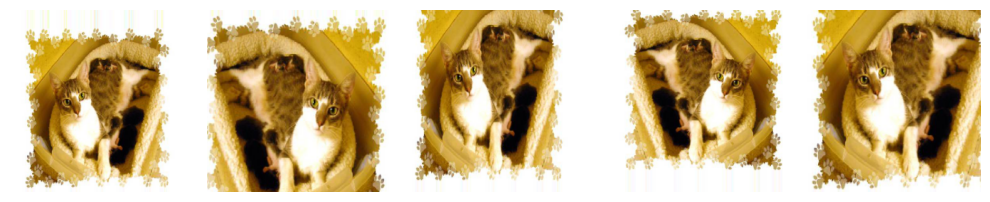

In [29]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [30]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [31]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


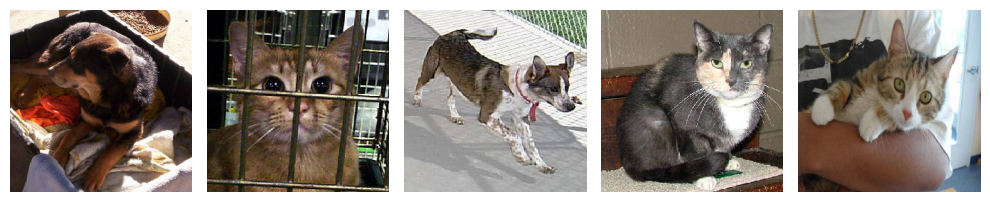

In [32]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [33]:
check_point_cb = callbacks.ModelCheckpoint('cat_dog.h5',save_best_only = True)
early_stopping_cb = callbacks.EarlyStopping(patience= 5 ,monitor = 'val_loss',
                                            restore_best_weights = True)

In [34]:
# VGG16 구현

def vgg16_model_maker(train_data_gen ,val_data_gen, epochs , batch_size , optimizer):

  input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
  x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
  x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.MaxPool2D((2, 2))(x)

  x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.MaxPool2D((2, 2))(x)

  x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.MaxPool2D((2, 2))(x)

  x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.MaxPool2D((2, 2))(x)

  x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.MaxPool2D((2, 2))(x)

  x=tf.keras.layers.Flatten()(x)
  x=tf.keras.layers.Dense(4096, activation='relu')(x)
  x=tf.keras.layers.Dense(4096, activation='relu')(x)
  x=tf.keras.layers.Dense(1000, activation='relu')(x)
  out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
  model.summary()

  loss_function = tf.keras.losses.binary_crossentropy
  optimize = optimizer
  model.compile(loss = loss_function,
                optimizer = optimizer,
                metrics='accuracy')

  history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs = epochs,
      validation_data=val_data_gen,
      callbacks= [check_point_cb , early_stopping_cb ],
      validation_freq=1)

  return history

In [35]:
history = vgg16_model_maker(train_data_gen ,val_data_gen, epochs = epochs , batch_size = batch_size , optimizer='SGD')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_10 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 128, 128, 128)     7385

In [36]:
# test data generator
image_gen_test = ImageDataGenerator(rescale=1./255,
                                     rotation_range= 5,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

-  검증용 test data 는 val_data 보다 변화량을 더 추가 했다.

In [37]:
test_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [46]:
# model 검증
from keras.models import load_model
model_vgg16 =load_model('cat_dog.h5')
model_vgg16.evaluate_generator(val_data_gen, total_val//batch_size, verbose = 1)

<ipython-input-46-8fa98c410004>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_vgg16.evaluate_generator(val_data_gen, total_val//batch_size, verbose = 1)


62/62 [==============================] - 6s 94ms/step - loss: 0.5253 - accuracy: 0.7339


[0.5252642631530762, 0.7338709831237793]

In [52]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    # axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# plot_model_history(history)

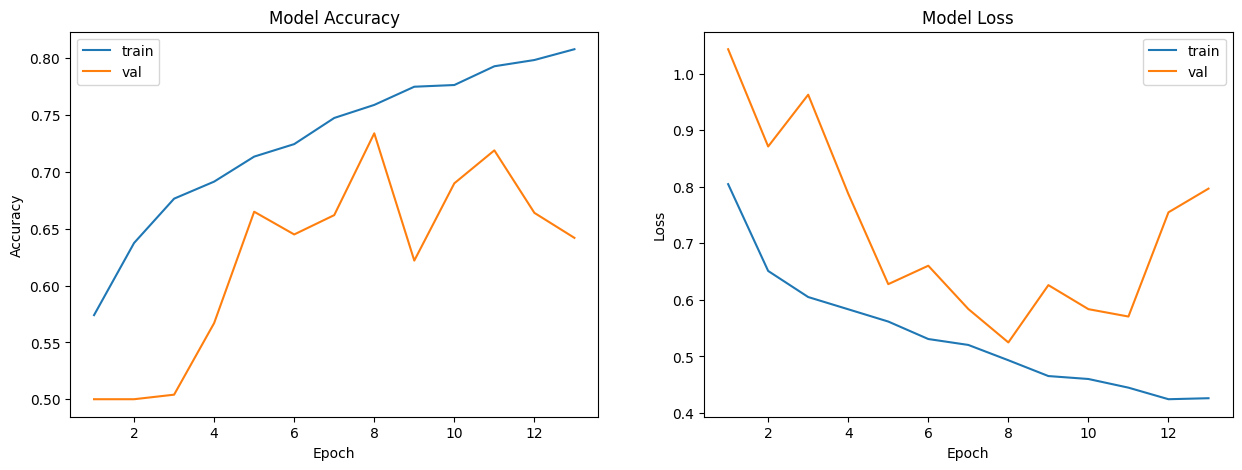

In [53]:
plot_model_history(history)

In [54]:
tf.keras.backend.clear_session()

In [55]:
# Pre-trained VGG 16

def vgg16_pre_train_model_maker(train_data_gen ,val_data_gen, epochs , batch_size , optimizer , freeze_index):

  # VGG16 모델 불러오기 (pre-trained 가중치 포함)
  pre_trained_model = VGG16(input_shape=(224,224,3), include_top=False, weights="imagenet")


  for layer in pre_trained_model.layers[:freeze_index]:
      layer.trainable = False
  for layer in pre_trained_model.layers[freeze_index:]:
      layer.trainable = True

  last_output = pre_trained_model.output

  # x = GlobalMaxPooling2D()(last_output)
  x = Flatten()(last_output)
  x = Dense(512, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(pre_trained_model.input, x)

  model.summary()

  loss_function = tf.keras.losses.binary_crossentropy
  optimize = optimizer
  model.compile(loss = loss_function,
                optimizer = optimizer,
                metrics='accuracy')

  history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs = epochs,
      validation_data=val_data_gen,
      callbacks = [check_point_cb,early_stopping_cb],
      validation_freq = 1)

  return history

In [57]:
history1 = vgg16_pre_train_model_maker(train_data_gen ,val_data_gen, epochs = epochs , batch_size = batch_size , optimizer = 'SGD' , freeze_index = 11)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

- 처음 model 생성시에 model의 학습 epoch 을 임의로 잡았더니 학습 진행이 전혀 되지 않았다.

- model fit 과 data_augmentation 의 batch 를 맞춰 주고 나니 좋은 결과가 나오기 시작 했다.

- 그리고 Opimizer 는 'Adam' 보다는 'SGD' 가 더 좋은 성능이 나왔다는 것을 선행 실험에서 알 수 있었다.

- 향후에도 주의 할 내용이다.

In [58]:
# pre_trained VGG16 model 검증
model_vgg16 = load_model('cat_dog.h5')
model_vgg16.evaluate_generator(test_data_gen, total_val//batch_size, verbose = 1)

<ipython-input-58-b922dce707dc>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_vgg16.evaluate_generator(test_data_gen, total_val//batch_size, verbose = 1)


62/62 [==============================] - 6s 90ms/step - loss: 0.0634 - accuracy: 0.9758


[0.06340931355953217, 0.975806474685669]

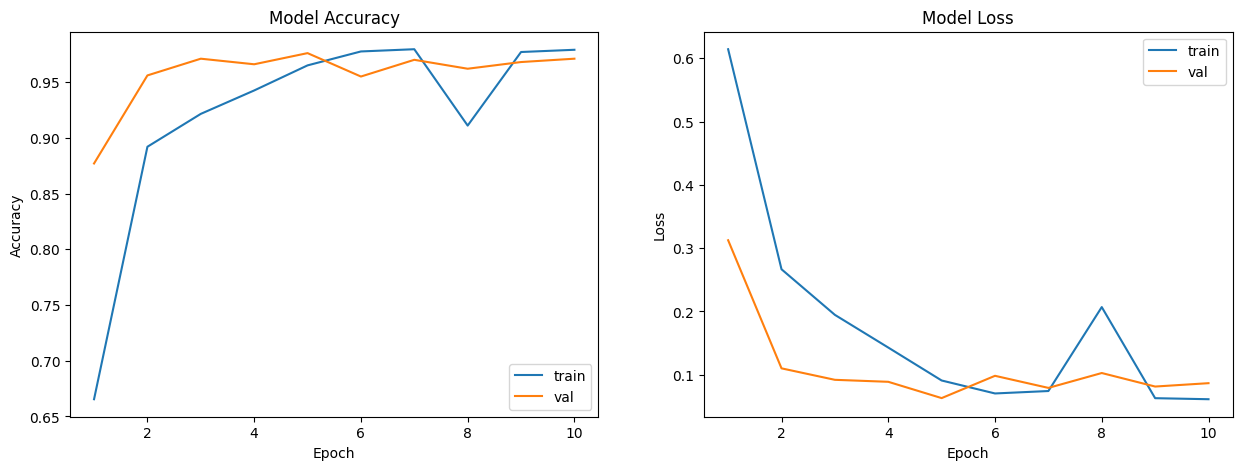

In [59]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    # axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history1)

 - 마지막으로 CNN 을 실행 해보고 , Pre-Train VGG16 과 비교 해 보도록 한다.

In [61]:
# CNN 구현
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

history = model.fit(
    train_data_gen,
    steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
    epochs=30,
    validation_data= val_data_gen)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [62]:
model.evaluate_generator(test_data_gen, total_val//batch_size, workers=12,verbose = 2)

<ipython-input-62-44bb57de7690>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_data_gen, total_val//batch_size, workers=12,verbose = 2)


62/62 - 4s - loss: 0.5626 - acc: 0.7147 - 4s/epoch - 67ms/step


[0.5625587701797485, 0.7147177457809448]

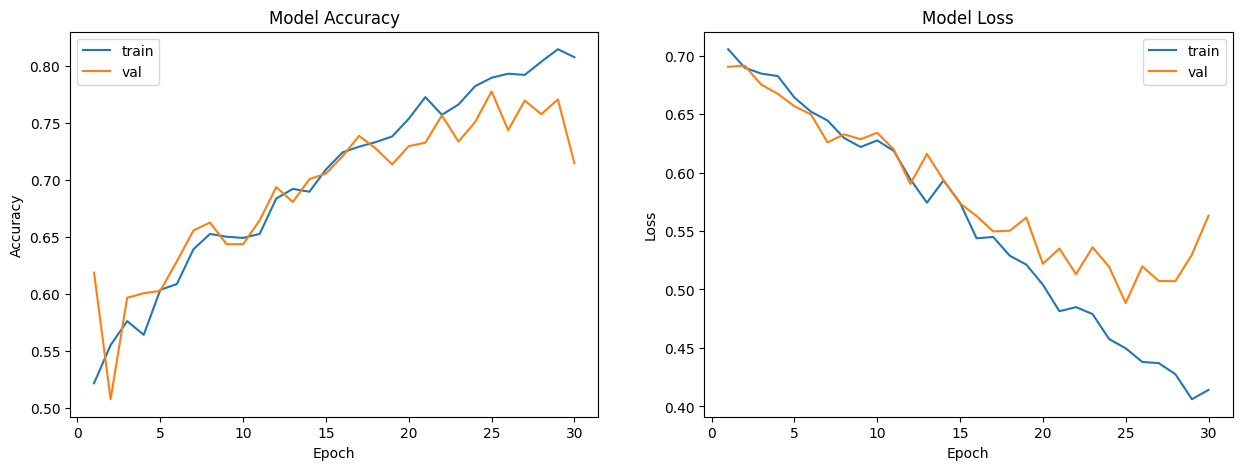

In [64]:
# CNN accuracy / loss 시각화
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    # axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

## 결론

- 구현한 VGG16 , CNN 에 비해서 Pre-trained VGG16 의 성능은 매우 높았다.
- 중간 batch 문제에 대한 오류가 아니었다면 , 조금 더 합당한 결론을 내릴 수 있지 않았을까 생각 된다.